In [2]:
from __future__ import division
import time
import torch 
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import cv2 
from util import *
from darknet import Darknet
from preprocess import prep_image, inp_to_image, letterbox_image
import pandas as pd
import random 
import pickle as pkl
import argparse


def get_test_input(input_dim, CUDA):
    img = cv2.imread("dog-cycle-car.png")
    img = cv2.resize(img, (input_dim, input_dim)) 
    img_ =  img[:,:,::-1].transpose((2,0,1))
    img_ = img_[np.newaxis,:,:,:]/255.0
    img_ = torch.from_numpy(img_).float()
    img_ = Variable(img_)
    
    if CUDA:
        img_ = img_.cuda()
    
    return img_

def prep_image(img, inp_dim):
    """
    Prepare image for inputting to the neural network. 
    
    Returns a Variable 
    """

    orig_im = img
    dim = orig_im.shape[1], orig_im.shape[0]
    img = (letterbox_image(orig_im, (inp_dim, inp_dim)))
    img_ = img[:,:,::-1].transpose((2,0,1)).copy()
    img_ = torch.from_numpy(img_).float().div(255.0).unsqueeze(0)
    return img_, orig_im, dim

def write(x, img):
    c1 = tuple(x[1:3].int())
    c2 = tuple(x[3:5].int())
    cls = int(x[-1])
    label = "{0}".format(classes[cls])
    color = random.choice(colors)
    cv2.rectangle(img, c1, c2,color, 1)
    t_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_PLAIN, 1 , 1)[0]
    c2 = c1[0] + t_size[0] + 3, c1[1] + t_size[1] + 4
    cv2.rectangle(img, c1, c2,color, -1)
    cv2.putText(img, label, (c1[0], c1[1] + t_size[1] + 4), cv2.FONT_HERSHEY_PLAIN, 1, [225,255,255], 1);
    return img

def arg_parse():
    """
    Parse arguements to the detect module
    
    """
    
    
    parser = argparse.ArgumentParser(description='YOLO v3 Video Detection Module')
   
    parser.add_argument("--video", dest = 'video', help = 
                        "Video to run detection upon",
                        default = "video.avi", type = str)
    parser.add_argument("--dataset", dest = "dataset", help = "Dataset on which the network has been trained", default = "pascal")
    parser.add_argument("--confidence", dest = "confidence", help = "Object Confidence to filter predictions", default = 0.5)
    parser.add_argument("--nms_thresh", dest = "nms_thresh", help = "NMS Threshhold", default = 0.4)
    parser.add_argument("--cfg", dest = 'cfgfile', help = 
                        "Config file",
                        default = "cfg/yolov3.cfg", type = str)
    parser.add_argument("--weights", dest = 'weightsfile', help = 
                        "weightsfile",
                        default = "yolov3.weights", type = str)
    parser.add_argument("--reso", dest = 'reso', help = 
                        "Input resolution of the network. Increase to increase accuracy. Decrease to increase speed",
                        default = "416", type = str)
    return parser.parse_args()




ModuleNotFoundError: No module named 'util'

In [6]:


confidence = float(0.7)
nms_thesh = float(0.4)
start = 0

CUDA = torch.cuda.is_available()

num_classes = 80

CUDA = torch.cuda.is_available()

bbox_attrs = 5 + num_classes

print("Loading network.....")
model = Darknet(args.cfgfile)
model.load_weights(args.weightsfile)
print("Network successfully loaded")

model.net_info["height"] = args.reso
inp_dim = int(model.net_info["height"])
assert inp_dim % 32 == 0 
assert inp_dim > 32

if CUDA:
    model.cuda()

model(get_test_input(inp_dim, CUDA), CUDA)

model.eval()

videofile = args.video

cap = cv2.VideoCapture(videofile)

assert cap.isOpened(), 'Cannot capture source'

frames = 0
start = time.time()    
while cap.isOpened():

    ret, frame = cap.read()
    if ret:


        img, orig_im, dim = prep_image(frame, inp_dim)

        im_dim = torch.FloatTensor(dim).repeat(1,2)                        


        if CUDA:
            im_dim = im_dim.cuda()
            img = img.cuda()

        with torch.no_grad():   
            output = model(Variable(img), CUDA)
        output = write_results(output, confidence, num_classes, nms = True, nms_conf = nms_thesh)

        if type(output) == int:
            frames += 1
            print("FPS of the video is {:5.2f}".format( frames / (time.time() - start)))
            cv2.imshow("frame", orig_im)
            key = cv2.waitKey(1)
            if key & 0xFF == ord('q'):
                break
            continue




        im_dim = im_dim.repeat(output.size(0), 1)
        scaling_factor = torch.min(inp_dim/im_dim,1)[0].view(-1,1)

        output[:,[1,3]] -= (inp_dim - scaling_factor*im_dim[:,0].view(-1,1))/2
        output[:,[2,4]] -= (inp_dim - scaling_factor*im_dim[:,1].view(-1,1))/2

        output[:,1:5] /= scaling_factor

        for i in range(output.shape[0]):
            output[i, [1,3]] = torch.clamp(output[i, [1,3]], 0.0, im_dim[i,0])
            output[i, [2,4]] = torch.clamp(output[i, [2,4]], 0.0, im_dim[i,1])

        classes = load_classes('data/coco.names')
        colors = pkl.load(open("pallete", "rb"))

        list(map(lambda x: write(x, orig_im), output))


        cv2.imshow("frame", orig_im)
        key = cv2.waitKey(1)
        if key & 0xFF == ord('q'):
            break
        frames += 1
        print("FPS of the video is {:5.2f}".format( frames / (time.time() - start)))


    else:
        break








usage: ipykernel_launcher.py [-h] [--video VIDEO] [--dataset DATASET]
                             [--confidence CONFIDENCE]
                             [--nms_thresh NMS_THRESH] [--cfg CFGFILE]
                             [--weights WEIGHTSFILE] [--reso RESO]
ipykernel_launcher.py: error: unrecognized arguments: -f /Users/Eren/Library/Jupyter/runtime/kernel-16db8a81-c358-43b1-a8db-14ac9259388c.json


SystemExit: 2

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2918: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# Load Dependencies

In [145]:

# Some code sourced from:

#############################################
# Object detection - YOLO - OpenCV
# Author : Arun Ponnusamy   (July 16, 2018)
# Website : http://www.arunponnusamy.com
############################################


import cv2
import numpy as np
import matplotlib.pyplot as plt


import pandas as pd


from scipy.spatial import distance
import tensorflow as tf
import seaborn as sns

from sklearn.model_selection import train_test_split

from keras.models import Model, load_model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from keras import backend as K


%matplotlib inline





# Functions

In [199]:




def get_output_layers(net):
    
    layer_names = net.getLayerNames()
    
    output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]

    return output_layers


def draw_prediction(img, class_id, confidence, x, y, x_plus_w, y_plus_h):

    label = str(classes[class_id])

    color = COLORS[class_id]

    cv2.rectangle(img, (x,y), (x_plus_w,y_plus_h), color, 2)

    cv2.putText(img, label, (x-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)


def get_yolo_output(image):

    Width = image.shape[1]
    Height = image.shape[0]
    scale = 0.00392

    blob = cv2.dnn.blobFromImage(image, scale, (416,416), (0,0,0), True, crop=False)

    net.setInput(blob)

    outs = net.forward(get_output_layers(net))


    class_ids = []
    confidences = []
    boxes = []
    conf_threshold = 0.5
    nms_threshold = 0.4


    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:
                center_x = int(detection[0] * Width)
                center_y = int(detection[1] * Height)
                w = int(detection[2] * Width)
                h = int(detection[3] * Height)
                x = center_x - w / 2
                y = center_y - h / 2
                class_ids.append(class_id)
                confidences.append(float(confidence))
                boxes.append([x, y, w, h])


    indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)
    
    boxes_nms = []
    class_ids_nms = []
    confidences_nms = []
    
    
    for i in indices:
        i = i[0]
        boxes_nms.append(boxes[i])
        class_ids_nms.append(class_ids[i])
        confidences_nms.append(confidences[i])
    
    return boxes_nms, class_ids_nms, confidences_nms


def print_on_image(image, boxes_nms, class_ids_nms, confidences_nms):

    cv2.polylines(image,swalk_pts,True,(0,255,255),thickness=3)
    cv2.polylines(image,lane_pts,True,(255,0,255),thickness=3)
    
    
    for i, box in enumerate(boxes_nms):
        x = box[0]
        y = box[1]
        w = box[2]
        h = box[3]
        draw_prediction(image, class_ids_nms[i], confidences_nms[i], round(x), round(y), round(x+w), round(y+h))
        

        
def create_grid_image(boxes_nms, class_ids_nms, confidences_nms, grid_scaling_factor, grid_background):
    
    
    grid_vehicles   = np.zeros((grid_y_size,grid_x_size), dtype = np.int8)
    grid_person     = np.zeros((grid_y_size,grid_x_size), dtype = np.int8)
    grid_bicycle    = np.zeros((grid_y_size,grid_x_size), dtype = np.int8)
    
    for i, box in enumerate(boxes_nms):

        x = round(box[0])
        y = round(box[1])
        w = box[2]
        h = box[3]

        x_plus_w = round(x+w)
        y_plus_h = round(y+h)


        x = round(x/grid_scaling_factor)
        y = round(y/grid_scaling_factor)
        x_plus_w = round(x_plus_w/grid_scaling_factor)
        y_plus_h = round(y_plus_h/grid_scaling_factor)
        
        if class_ids_nms[i] in [2, 3, 5, 6, 7]:  # Motorized vehicles [car, motorcycle, bus, train, truck]
            
            cv2.rectangle(grid_vehicles, (x,y), (x_plus_w,y_plus_h), vehicle_w, -1)


        elif class_ids_nms[i]==0:  # Person
            
            cv2.rectangle(grid_person, (x,y), (x_plus_w,y_plus_h), person_w, -1) 
            
        elif class_ids_nms[i]==1:  # Bicycle
            
            cv2.rectangle(grid_bicycle, (x,y), (x_plus_w,y_plus_h), bicycle_w, -1)
            
        else:
            continue
    
    grid_overflow = np.zeros((grid_y_size,grid_x_size), dtype = np.int16)    
    grid_overflow = np.array([grid_background,grid_vehicles,grid_person,grid_bicycle])
    grid_overflow = grid_overflow.sum(axis=0)
    grid_overflow[grid_overflow>127] = 127
    grid_overflow[grid_overflow<-128] = -128
    grid = np.array(grid_overflow,dtype=np.int8)

    return grid
       

    
def create_grid(boxes_nms, class_ids_nms, confidences_nms, grid_scaling_factor, grid_background,
               vehicles=False,
               persons=False,
               bicycles=False):
    
    options = [vehicles, persons, bicycles]
    num_channels = options.count(True)
    
    grid = np.zeros((num_channels,grid_y_size,grid_x_size), dtype = bool)
    
    
    grid_vehicles   = np.zeros((grid_y_size,grid_x_size), dtype = bool)
    grid_person     = np.zeros((grid_y_size,grid_x_size), dtype = bool)
    grid_bicycle    = np.zeros((grid_y_size,grid_x_size), dtype = bool)
    
    present_val = 1
    
    for i, box in enumerate(boxes_nms):

        x = round(box[0])
        y = round(box[1])
        w = box[2]
        h = box[3]

        x_plus_w = round(x+w)
        y_plus_h = round(y+h)


        x = round(x/grid_scaling_factor)
        y = round(y/grid_scaling_factor)
        x_plus_w = round(x_plus_w/grid_scaling_factor)
        y_plus_h = round(y_plus_h/grid_scaling_factor)
        
        
        if class_ids_nms[i] in [2, 3, 5, 6, 7]:  # Motorized vehicles [car, motorcycle, bus, train, truck]
            
            grid_vehicles[y:y_plus_h+1,x:x_plus_w+1] = present_val

        elif class_ids_nms[i]==0:  # Person
            
            grid_person[y:y_plus_h+1,x:x_plus_w+1] = present_val
            
        elif class_ids_nms[i]==1:  # Bicycle
            
            grid_bicycle[y:y_plus_h+1,x:x_plus_w+1] = present_val
            
        else:
            continue


    j = 0
    if vehicles:
        grid[j] = grid_vehicles
        j = j+1
    if persons:
        grid[j] = grid_person
        j = j+1
    if bicycles:
        grid[j] = grid_bicycle
        j = j+1
    
    return grid
       



# Spatial and Time Scaling Coefficients
* "seconds" represents the time intervals in seconds at which samples will be taken from the video.    
* "grid_scaling_factor" represents the factor by which the grid will be shrunk.

In [200]:
seconds = 5
grid_scaling_factor = 32

# Background Areas

In [201]:

########### Background Areas #############

#lanes

lane_pts = []
lane_pts_1 = np.array([[540,0],[483,303],[314,555],[0,915],[0,1080],[625,1080],[708,719],[745,544],[763,362],[687,154],[791,310],[822,396],[835,582],[806,861],[779,1080],[1114,1080],[1060,664],[988,418],[924,317],[662,0]], np.int32)
lane_pts_1 = lane_pts_1.reshape((-1,1,2))

lane_pts_2 = np.array([[1920,600],[1832,660],[1760,773],[1692,907],[1660,1080],[1140,1080],[1245,893],[1418,691],[1590,569],[1782,480],[1920,421]], np.int32)
lane_pts_2 = lane_pts_2.reshape((-1,1,2))

lane_pts.append(lane_pts_1)
lane_pts.append(lane_pts_2)


lane_pts_grid = []

for pts in lane_pts:
    grid_pts = np.divide(pts,grid_scaling_factor)
    np.round_(grid_pts)
    grid_pts = np.array(grid_pts,dtype=np.int32)
    lane_pts_grid.append(grid_pts)



#sidewalks

swalk_pts = []
swalk_pts_1 = np.array([[454,0],[540,0],[514,143],[448,149],[383,306],[483,303],[314,555],[0,915],[0,425],[179,356]], np.int32)
swalk_pts_1 = swalk_pts_1.reshape((-1,1,2))

swalk_pts_2 = np.array([[986,265],[1173,264],[1268,319],[1484,291],[1600,296],[1920,224],[1920,281],[1280,529],[1151,500]], np.int32)
swalk_pts_2 = swalk_pts_2.reshape((-1,1,2))

swalk_pts_3 = np.array([[1920,600],[1920,1080],[1660,1080],[1692,907],[1760,773],[1832,660]], np.int32)
swalk_pts_3 = swalk_pts_3.reshape((-1,1,2))


swalk_pts.append(swalk_pts_1)
swalk_pts.append(swalk_pts_2)
swalk_pts.append(swalk_pts_3)


swalk_pts_grid = []

for pts in swalk_pts:
    grid_pts = np.divide(pts,grid_scaling_factor)
    np.round_(grid_pts)
    grid_pts = np.array(grid_pts,dtype=np.int32)
    swalk_pts_grid.append(grid_pts)
    


#out of bounds (oob) areas


#median spaces



## Grid Weights

In [202]:

########### Grid Weights #############


lane_w = 32
swalk_w = -32
oob_w = -127
med_sp_w = 0


vehicle_w = 64
person_w = -64
bicycle_w = 32

# obj_w = 




## Load Model

In [203]:

##################################################################### 

classes = None

with open('yolov3.txt', 'r') as f:
    classes = [line.strip() for line in f.readlines()]

COLORS = np.random.uniform(0, 255, size=(len(classes), 3))

GREYSCALE = np.random.uniform(0, 255, size=(len(classes)))

net = cv2.dnn.readNet('yolov3.weights', 'yolov3.cfg')


#image = cv2.imread('dog.jpg')

#####################################################################




## Load Video

In [216]:





videofile = 'videos/DSC_0005.MOV'

cap = cv2.VideoCapture(videofile)

assert cap.isOpened(), 'Cannot capture source'

frameId = int(round(cap.get(1))) #current frame number, rounded b/c sometimes you get frame intervals which aren't integers...this adds a little imprecision but is likely good enough
success,image = cap.read()



fps = cap.get(cv2.CAP_PROP_FPS) # Gets the frames per second
num_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT) # Gets the total number of frames




frame_width = cap.get(cv2.CAP_PROP_FRAME_WIDTH) # Gets the frame width
frame_height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT) # Gets the frame width

grid_x_size = int(round(frame_width/grid_scaling_factor))
grid_y_size = int(round(frame_height/grid_scaling_factor))


multiplier = int(round(fps * seconds))
num_scenes = int(round(num_frames/(fps * seconds))+1)


grids_v       = np.zeros((num_scenes,1,grid_y_size,grid_x_size), dtype = bool)
grids_p       = np.zeros((num_scenes,1,grid_y_size,grid_x_size), dtype = bool)
grids_vp      = np.zeros((num_scenes,2,grid_y_size,grid_x_size), dtype = bool)
grids_vpb     = np.zeros((num_scenes,3,grid_y_size,grid_x_size), dtype = bool)


frameIds    = np.zeros((num_scenes), dtype = np.int32)
time_sec_count = np.zeros((num_scenes), dtype = np.int32)


#################### Initiate Process ################

#################### Create Background Grid ################

grid_background = np.zeros((grid_y_size,grid_x_size), dtype = np.int8)

# Mark background
cv2.fillPoly(grid_background,lane_pts_grid,lane_w)
cv2.fillPoly(grid_background,swalk_pts_grid,swalk_w)

print('FPS: ', fps)



FPS:  23.976023976023978


## Process Video

In [217]:


############################################################

i = 0

while success:

    if frameId % multiplier == 0:
        

        
#############################################################

        
        boxes_nms, class_ids_nms, confidences_nms = get_yolo_output(image)
        
        second_count = round(frameId/fps)
        print (second_count)
        
        grid = create_grid(boxes_nms, class_ids_nms, confidences_nms, grid_scaling_factor,grid_background,
                           vehicles = True,
                           persons = True,
                           bicycles = True)
        
        
        print (grid[:2].shape)
        
        grids_v[i] = grid[0]
        grids_p[i] = grid[1]
        grids_vp[i] = grid[:2]
        grids_vpb[i] = grid
        
        
        
        frameIds[i] = frameId
        time_sec_count[i] = second_count
        
        
        
        
        
        
        if frameId % (multiplier) == 0:
            
            
            grid_rep = np.array(grid[1],dtype=np.uint8)
            grid_rep = np.multiply(grid_rep,255)
            cv2.imwrite("output/representations/rep%d.jpg" % frameId, grid_rep)
        
            grid_image = create_grid_image(boxes_nms, class_ids_nms, confidences_nms, grid_scaling_factor,grid_background)
            grid_image_16_bit = np.array(grid_image,dtype=np.int16)
            grid_image_16_bit = np.add(grid_image_16_bit,128)
            grid_image_unsigned = np.array(grid_image_16_bit,dtype=np.uint8)
            cv2.imwrite("output/grids/grid%d.jpg" % frameId, grid_image_unsigned)

            print_on_image(image, boxes_nms, class_ids_nms, confidences_nms)

            cv2.imwrite("output/frames/frame%d.jpg" % frameId, image)
        
        
        i= i+1
        
        #print ('One image done')
        
        
    frameId = int(round(cap.get(1))) #current frame number, rounded b/c sometimes you get frame intervals which aren't integers...this adds a little imprecision but is likely good enough
    success, image = cap.read()


        #plt.figure(figsize = (15, 15))
        #plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    
#cv2.imwrite("object-detection.jpg", image)
#cv2.destroyAllWindows()

print (i)

cap.release()



print ("Complete")





0
(2, 34, 60)
5
(2, 34, 60)
10
(2, 34, 60)
15
(2, 34, 60)
20
(2, 34, 60)
25
(2, 34, 60)


KeyboardInterrupt: 

In [153]:
np.save("grid_arrays/grids_v.npy", grids_v)
np.save("grid_arrays/grids_p.npy", grids_p)
np.save("grid_arrays/grids_vp.npy", grids_vp)
np.save("grid_arrays/grids_vpb.npy", grids_vpb)

np.save("grid_arrays/frameIds.npy", frameIds)
np.save("grid_arrays/time_sec_count.npy", time_sec_count)

In [221]:
grids = np.load("grid_arrays/grids.npy")
frameIds = np.load("grid_arrays/frameIds.npy")

In [222]:

j = 0
for i in grids[2].flat:
    if i == True:
        j = j+1
        
print(j)


128


# Learning Algorithms on Grids
## Divergence from Average Inquiry

In [232]:
mean_grid = np.mean(grids, axis=0)

threshold = 200

dists = 0
j = 0
for grid,frameId  in zip(grids,frameIds):
    grid_numeric = np.array(grid, dtype = np.float64)
    var = distance.sqeuclidean(np.ravel(grid_numeric),np.ravel(mean_grid))
    dists = dists + var
    if var > threshold:
        j = j+1
        print(frameId)


mean = dists/frameIds.size
print(mean)

1080
3708
3732
3744
3792
3804
3816
3828
3840
3852
3864
3876
3888
3900
3912
3924
3936
7452
7464
7500
7512
7524
7536
7548
7560
7572
7584
7656
7812
7848
7860
7872
7884
7896
7908
7920
7932
11172
11184
12120
12480
12540
12624
13068
13080
13200
13212
13248
13272
13728
13740
13752
13764
128.67264789749873


In [234]:
mean_grid = np.multiply(mean_grid,255)
cv2.imwrite("mean_grid.jpg", mean_grid)




True

In [235]:
maxi = np.amax(mean_grid)
print (maxi)

178.98834304746043


## Autoencoder

In [168]:
RANDOM_SEED = 42

In [169]:
test_size=0.2

train_end_ind = round((1-test_size)*len(grids))

### 1D Autoencoder

In [159]:
print(grids.shape)



X_train, X_test = grids.reshape((len(grids), np.prod(grids.shape[1:])))[:train_end_ind], grids.reshape((len(grids), np.prod(grids.shape[1:])))[train_end_ind:]
Id_train, Id_test = frameIds[:train_end_ind], frameIds[train_end_ind:]

print(len(grids))

#X_train, X_test, Id_train, Id_test = train_test_split(grids.reshape((len(grids), np.prod(grids.shape[1:]))), frameIds, test_size=0.2, random_state=RANDOM_SEED)

print(grids.shape)

print(X_train.shape)
print(X_test.shape)
print(34*60)

(1201, 34, 60)
1201
(1201, 34, 60)
(961, 2040)
(240, 2040)
2040


In [160]:
input_dim = np.prod(grids.shape[1:])
encoding_dim = 14

print(input_dim)

input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

2040


In [161]:
nb_epoch = 100
batch_size = 32

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="models/model.h5",
                               verbose=0,
                               save_best_only=True)


history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer]).history

Train on 961 samples, validate on 240 samples
Epoch 1/100
961/961 [==============================] - 2s 2ms/step - loss: 0.0871 - acc: 0.0010 - val_loss: 0.1048 - val_acc: 0.0000e+00
Epoch 2/100
961/961 [==============================] - 0s 247us/step - loss: 0.0746 - acc: 0.0042 - val_loss: 0.0901 - val_acc: 0.0000e+00
Epoch 3/100
961/961 [==============================] - 0s 259us/step - loss: 0.0679 - acc: 0.0010 - val_loss: 0.0864 - val_acc: 0.0000e+00
Epoch 4/100
961/961 [==============================] - 0s 257us/step - loss: 0.0648 - acc: 0.0000e+00 - val_loss: 0.0850 - val_acc: 0.0000e+00
Epoch 5/100
961/961 [==============================] - 0s 247us/step - loss: 0.0631 - acc: 0.0000e+00 - val_loss: 0.0830 - val_acc: 0.0000e+00
Epoch 6/100
961/961 [==============================] - 0s 246us/step - loss: 0.0616 - acc: 0.0000e+00 - val_loss: 0.0819 - val_acc: 0.0000e+00
Epoch 7/100
961/961 [==============================] - 0s 244us/step - loss: 0.0605 - acc: 0.0000e+00 - val_lo

961/961 [==============================] - 0s 240us/step - loss: 0.0485 - acc: 0.0114 - val_loss: 0.0790 - val_acc: 0.0125
Epoch 60/100
961/961 [==============================] - 0s 249us/step - loss: 0.0491 - acc: 0.0083 - val_loss: 0.0790 - val_acc: 0.0000e+00
Epoch 61/100
961/961 [==============================] - 0s 245us/step - loss: 0.0514 - acc: 0.0031 - val_loss: 0.0775 - val_acc: 0.0042
Epoch 62/100
961/961 [==============================] - 0s 244us/step - loss: 0.0490 - acc: 0.0094 - val_loss: 0.0770 - val_acc: 0.0000e+00
Epoch 63/100
961/961 [==============================] - 0s 246us/step - loss: 0.0489 - acc: 0.0062 - val_loss: 0.0777 - val_acc: 0.0042
Epoch 64/100
961/961 [==============================] - 0s 242us/step - loss: 0.0480 - acc: 0.0052 - val_loss: 0.0769 - val_acc: 0.0042
Epoch 65/100
961/961 [==============================] - 0s 244us/step - loss: 0.0475 - acc: 0.0062 - val_loss: 0.0789 - val_acc: 0.0000e+00
Epoch 66/100
961/961 [===========================

In [162]:
autoencoder = load_model('models/model.h5')

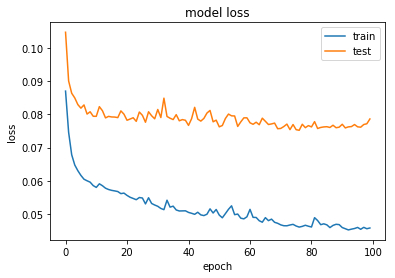

In [163]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [176]:
predictions = autoencoder.predict(X_test)

In [179]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'frameId': Id_test})


In [182]:
threshold = 0.08

y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
pred_frameIds = []
for y,frameId in zip(y_pred, Id_test):
    if y==1:
        pred_frameIds.append(frameId)
pred_frameIds.sort()
print(pred_frameIds)
    


[1068, 1080, 1092, 3660, 3684, 3696, 3708, 3720, 3732, 3744, 3756, 3780, 3792, 3804, 3816, 3828, 3840, 3852, 3864, 3876, 3888, 3900, 3936, 6420, 7440, 7464]


### 2D Convolutional Autoencoder

In [183]:
print(grids.shape)



X_train, X_test = grids.reshape((len(grids), grids.shape[1], grids.shape[2], 1))[:train_end_ind], grids.reshape((len(grids), grids.shape[1], grids.shape[2], 1))[train_end_ind:]
Id_train, Id_test = frameIds[:train_end_ind], frameIds[train_end_ind:]

print(len(grids))

#X_train, X_test, Id_train, Id_test = train_test_split(grids.reshape((len(grids), np.prod(grids.shape[1:]))), frameIds, test_size=0.2, random_state=RANDOM_SEED)

print(grids.shape)

print(X_train.shape)
print(X_test.shape)
print(34*60)

(1201, 34, 60)
1201
(1201, 34, 60)
(961, 34, 60, 1)
(240, 34, 60, 1)
2040


In [184]:
input_dim = (grids.shape[1], grids.shape[2], 1)

print(input_dim)


input_img = Input(shape=input_dim)  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (4, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

(34, 60, 1)


In [185]:
checkpointer = ModelCheckpoint(filepath="models/model_2D_conv.h5",
                               verbose=0,
                               save_best_only=True)


history = autoencoder.fit(X_train, X_train,
                epochs=50,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(X_test, X_test),
                callbacks=[checkpointer]).history

Train on 961 samples, validate on 240 samples
Epoch 1/50
961/961 [==============================] - 9s 9ms/step - loss: 0.5010 - val_loss: 0.4099
Epoch 2/50
961/961 [==============================] - 7s 7ms/step - loss: 0.2544 - val_loss: 0.2375
Epoch 3/50
961/961 [==============================] - 6s 7ms/step - loss: 0.1710 - val_loss: 0.2045
Epoch 4/50
961/961 [==============================] - 6s 7ms/step - loss: 0.1535 - val_loss: 0.1880
Epoch 5/50
961/961 [==============================] - 6s 7ms/step - loss: 0.1415 - val_loss: 0.1786
Epoch 6/50
961/961 [==============================] - 6s 7ms/step - loss: 0.1324 - val_loss: 0.1662
Epoch 7/50
961/961 [==============================] - 7s 7ms/step - loss: 0.1252 - val_loss: 0.1587
Epoch 8/50
961/961 [==============================] - 7s 7ms/step - loss: 0.1194 - val_loss: 0.1523
Epoch 9/50
961/961 [==============================] - 7s 7ms/step - loss: 0.1144 - val_loss: 0.1463
Epoch 10/50
961/961 [==============================] -

In [186]:
autoencoder = load_model('models/model_2D_conv.h5')

In [187]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        (None, 34, 60, 1)         0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 34, 60, 16)        160       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 17, 30, 16)        0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 17, 30, 8)         1160      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 9, 15, 8)          0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 9, 15, 8)          584       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 5, 8, 8)           0         
__________

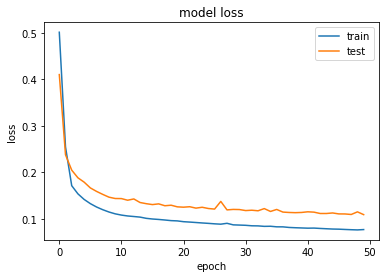

In [188]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [189]:
predictions = autoencoder.predict(X_test)

In [190]:
mse = np.mean(np.power(X_test - predictions, 2), axis=(1,2))
print(mse.shape)
error_df = pd.DataFrame({'reconstruction_error': mse.reshape((len(mse),)),
                        'frameId': Id_test})



(240, 1)


In [194]:
threshold = 0.05

y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
pred_frameIds = []
for y,frameId in zip(y_pred, Id_test):
    if y==1:
        pred_frameIds.append(frameId)
pred_frameIds.sort()
print(pred_frameIds)
    



[12264, 12480, 12492, 12540, 13080, 13164, 13200, 13212, 13236, 13248, 13272, 13296, 13308]
